This is a code for SARIMA model

In [84]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from itertools import product
import pandas as pd
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')



In [85]:
# Load the dataset
file_path = '../data/BR_param_norm.csv'
df = pd.read_csv(file_path, index_col='date', parse_dates=['date'])

# Assuming the target variable is the first column after date
# Adjust accordingly if the target variable is different
target_variable = df.columns[0]



In [86]:
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split


# Split the data into train, validation, and test sets
train_val, test = train_test_split(df[target_variable], test_size=0.2, shuffle=False)
train, validation = train_test_split(train_val, test_size=0.25, shuffle=False)  # 0.25 x 0.8 = 0.2

# Use auto_arima to find the best SARIMA parameters on the training set
auto_arima_model = auto_arima(train, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

# Display the best model summary
print(auto_arima_model.summary())



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-1400.546, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-1407.051, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-1404.702, Time=0.55 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-1403.553, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-1384.068, Time=0.03 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=-1402.514, Time=0.12 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=-1404.475, Time=0.11 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=-1401.954, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-1406.567, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-1406.224, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-1405.926, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.935 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observat

In [87]:
# Fit the model with the best parameters on the training set
model = auto_arima_model.fit(train)

# Forecast on the validation set
val_forecast = model.predict(n_periods=len(validation))



In [88]:
# Evaluate the forecast (e.g., using RMSE)
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(validation, val_forecast))
print(f'Validation RMSE: {rmse}')

# Finally, forecast on the test set using the model fitted on the combined training and validation set
combined_train_val = pd.concat([train, validation])
model_refit = auto_arima_model.fit(combined_train_val)
test_forecast = model_refit.predict(n_periods=len(test))

# Evaluate the test forecast (e.g., using RMSE)
test_rmse = sqrt(mean_squared_error(test, test_forecast))
print(f'Test RMSE: {test_rmse}')

Validation RMSE: 0.008315381869094546
Test RMSE: 0.011176992074644888


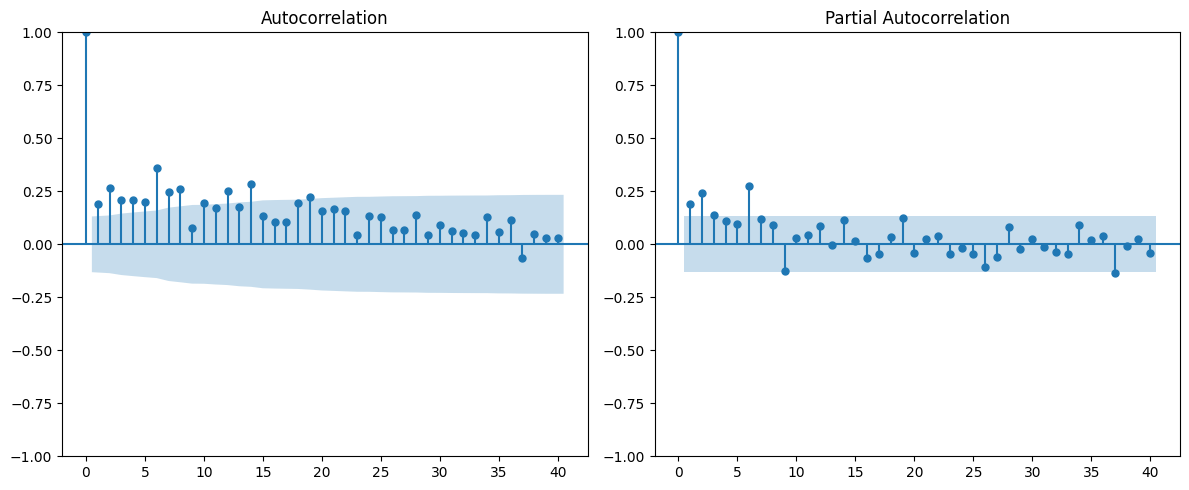

ACF and PACF plots generated.


In [110]:
import statsmodels.api as sm

model_residuals = model.resid()

# Plot ACF and PACF for the residuals
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sm.graphics.tsa.plot_acf(model_residuals, lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(model_residuals, lags=40, ax=ax[1])

plt.tight_layout()
plt.show()

print('ACF and PACF plots generated.')

In [105]:
# Convert the series to dataframes
train_df = pd.DataFrame({'date': pd.to_datetime(train.index), target_variable: train.values}).set_index('date').to_period('M')
validation_df = pd.DataFrame({'date': pd.to_datetime(validation.index), target_variable: validation.values}).set_index('date').to_period('M')
test_df = pd.DataFrame({'date': pd.to_datetime(test.index), target_variable: test.values}).set_index('date').to_period('M')

# Convert index to datetime objects
validation_df.index = validation_df.index.to_timestamp()
test_df.index = test_df.index.to_timestamp()
train_df.index = train_df.index.to_timestamp()


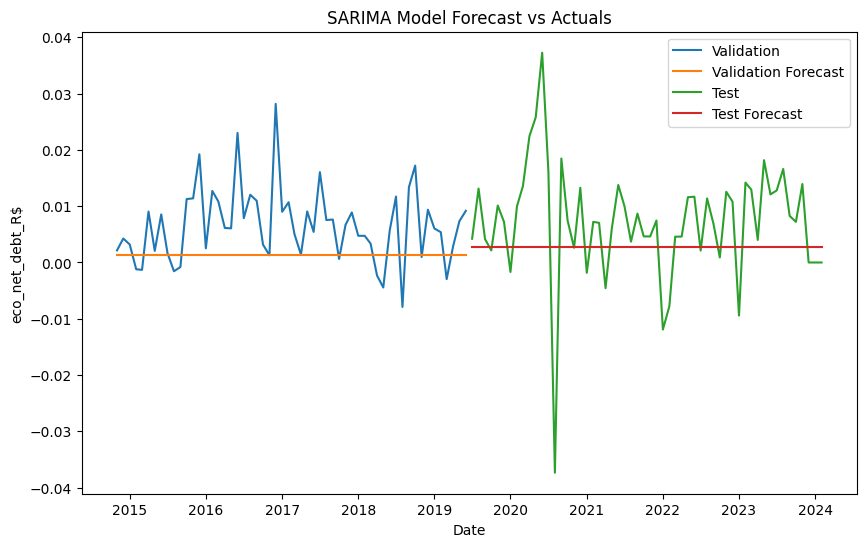

In [107]:
# Plotting
plt.figure(figsize=(10, 6))
#plt.plot(train_df[target_variable], label='Training')
plt.plot(validation_df[target_variable], label='Validation')
plt.plot(validation_df.index, val_forecast, label='Validation Forecast')
plt.plot(test_df[target_variable], label='Test')
plt.plot(test_df.index, test_forecast, label='Test Forecast')
plt.legend()
plt.title('SARIMA Model Forecast vs Actuals')
plt.ylabel(target_variable)
plt.xlabel('Date')
plt.show()